In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [435]:
# Load CSV files
customers = pd.read_csv("d_customer.csv")
orders = pd.read_csv("f_order.csv")
products = pd.read_csv("d_product.csv")
dates = pd.read_csv("d_date.csv")
countries = pd.read_csv("d_country.csv")

## EDA

### Data Preparation

In [137]:
# Merge datasets for full EDA
order_df = orders.merge(products, on='product_sku').merge(dates, on='date_id').merge(customers, on='customer_id').merge(countries, on='country_id')
# sorted_df = data.sort_values(by='id')
# sorted_df
order_df

,id,customer_id,date_id,product_sku,units_sold,category,group,product_name,price,date,year,month,country_id,country_name
0,1,815,12,P018,4,Snow,Apparel,M'S Loft Parka,490,2022-01-12,2022,1,5,Sweden
1,5404,815,481,P005,3,Cycling,Apparel,Essential Road Sock,20,2023-04-26,2023,4,5,Sweden
2,9116,815,651,P015,1,Snow,Goggles,Fovea,200,2023-10-13,2023,10,5,Sweden
3,236,676,12,P011,1,Snow,Helmets,Obex Bc Mips,270,2022-01-12,2022,1,5,Sweden
4,1338,676,124,P007,2,Cycling,Armor,Vpd System Torso,260,2022-05-04,2022,5,5,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3195,347,259,P014,2,Snow,Goggles,Nexal,230,2022-09-16,2022,9,3,Austria
9996,5465,347,467,P009,2,Cycling,Armor,Joint Vpd 2.0 Elbow,100,2023-04-12,2023,4,3,Austria
9997,987,347,99,P004,1,Cycling,Apparel,M'S Essential Road,120,2022-04-09,2022,4,3,Austria
9998,2331,347,189,P006,3,Cycling,Apparel,M'S Reform Enduro Jersey,90,2022-07-08,2022,7,3,Austria


In [487]:
order_df['order_revenue'] = order_df['price'] * order_df['units_sold']
p=sum(order_df['order_revenue'])
print(p)

4931560


In [483]:
revenue_by_year = order_df.groupby(['year'], observed=False)['order_revenue'].sum()

percent_revenue_by_year = ((revenue_by_year / revenue_by_year.sum()) * 100).sort_values(ascending=False)
percent_revenue_by_year = percent_revenue_by_year.apply(lambda x: "{:.2f}%".format(x))
print("Percentage of revenue by year:")
print(percent_revenue_by_year)
print("\n")

print(revenue_by_year.map(lambda x: f'{x:,}'))

print("\n")
#percentage increase from 2022 to 2023
percentage_increase= ((revenue_by_year.iloc[1]-revenue_by_year.iloc[0])/revenue_by_year.iloc[0])*100

print(f"Percentage Increase in Revenue from 2022 to 2023: {percentage_increase:.2f}%")


Percentage of revenue by year:
year
2023    60.24%
2022    39.76%
Name: order_revenue, dtype: object


year
2022    1,960,960
2023    2,970,600
Name: order_revenue, dtype: object


Percentage Increase in Revenue from 2022 to 2023: 51.49%


In [141]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10000 non-null  int64 
 1   customer_id    10000 non-null  int64 
 2   date_id        10000 non-null  int64 
 3   product_sku    10000 non-null  object
 4   units_sold     10000 non-null  int64 
 5   category       10000 non-null  object
 6   group          10000 non-null  object
 7   product_name   10000 non-null  object
 8   price          10000 non-null  int64 
 9   date           10000 non-null  object
 10  year           10000 non-null  int64 
 11  month          10000 non-null  int64 
 12  country_id     10000 non-null  int64 
 13  country_name   10000 non-null  object
 14  order_revenue  10000 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 1.1+ MB


In [142]:
order_df.isnull().sum().sort_values(ascending=False)

id               0
customer_id      0
date_id          0
product_sku      0
units_sold       0
category         0
group            0
product_name     0
price            0
date             0
year             0
month            0
country_id       0
country_name     0
order_revenue    0
dtype: int64

In [143]:

order_df['date'] = pd.to_datetime(order_df['date'])
month_map = { 1: 'january', 2: 'february', 3: 'march', 4: 'april',5: 'may',6: 'june',7: 'july', 8: 'august',9: 'september',10: 'october',11: 'november',12: 'december'}
order_df['month'] = order_df['date'].dt.month.map(month_map)



In [238]:
# Define the desired order of months
month_order = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']

# Convert the month column to a categorical data type with the desired order
order_df['month'] = pd.Categorical(order_df['month'], categories=month_order, ordered=True)


In [182]:
order_df['product_name'].value_counts()


product_name
M'S Reform Enduro Jersey    1413
M'S Essential Road          1322
M'S Coalesce Jacket         1050
Essential Road Sock          895
M'S Loft Parka               766
Vpd System Torso             463
Joint Vpd 2.0 Knee           453
Joint Vpd 2.0 Elbow          443
Otocon Race Mips             443
Omne Air Mips                442
Kortal Race Mips             441
Obex Bc Mips                 281
Nexal                        277
Zonula                       272
Fornix                       267
Fovea                        267
Levator Mips                 265
Meninx Rs Mips               240
Name: count, dtype: int64

## Understanding and Visualizing features with respect to revenue and units_sold.


#### Which category is generating most sales and revenue?

In [146]:
display(order_df[['product_name','category','group','units_sold','order_revenue']])

,product_name,category,group,units_sold,order_revenue
0,M'S Loft Parka,Snow,Apparel,4,1960
1,Essential Road Sock,Cycling,Apparel,3,60
2,Fovea,Snow,Goggles,1,200
3,Obex Bc Mips,Snow,Helmets,1,270
4,Vpd System Torso,Cycling,Armor,2,520
...,...,...,...,...,...
9995,Nexal,Snow,Goggles,2,460
9996,Joint Vpd 2.0 Elbow,Cycling,Armor,2,200
9997,M'S Essential Road,Cycling,Apparel,1,120
9998,M'S Reform Enduro Jersey,Cycling,Apparel,3,270


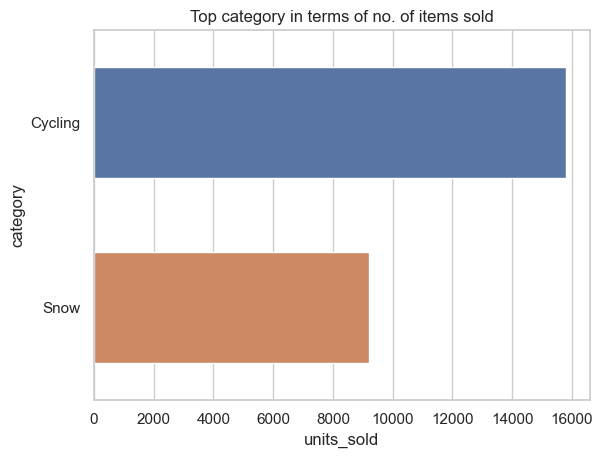

,category,units_sold
0,Cycling,15811
1,Snow,9206




Percentage of sales by product category:
category
Cycling    63.20%
Snow       36.80%
Name: units_sold, dtype: object




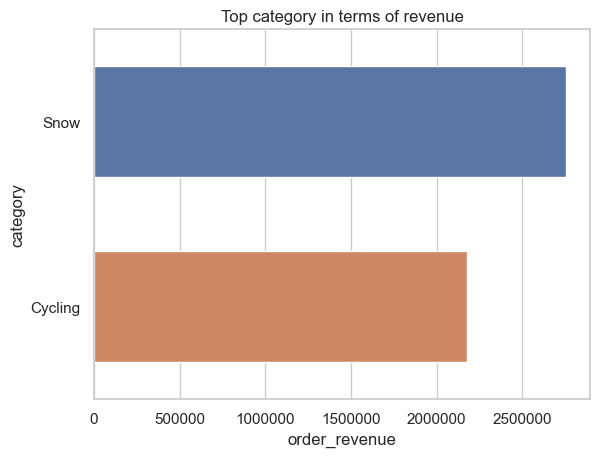

,category,order_revenue
1,Snow,2756290
0,Cycling,2175270




Percentage of revenue by product category:
category
Snow       55.89%
Cycling    44.11%
Name: order_revenue, dtype: object




In [424]:
#sales by category
sns.barplot(x='units_sold', y='category', width= 0.6,errorbar=None, data=order_df.groupby('category')['units_sold'].sum().reset_index().sort_values(
        by='units_sold', ascending=False))
plt.title('Top category in terms of no. of items sold')
plt.show()

print("\n")

display(order_df.groupby('category')['units_sold'].sum().reset_index().sort_values(by='units_sold', ascending=False))
print("\n")
sales_by_category = order_df.groupby('category')['units_sold'].sum()
percent_sales_by_category = ((sales_by_category / sales_by_category.sum()) * 100).sort_values(ascending=False)
percent_sales_by_category = percent_sales_by_category.apply(lambda x: "{:.2f}%".format(x))
print("Percentage of sales by product category:")
print(percent_sales_by_category)

print("\n")

#revenue by category
sns.barplot(x='order_revenue', y='category',width= 0.6,errorbar=None,data=order_df.groupby('category')['order_revenue'].sum().reset_index().sort_values(
    by='order_revenue', ascending=False))
plt.title('Top category in terms of revenue')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

print("\n")

display(order_df.groupby('category')['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False))

print("\n")

revenue_by_category = order_df.groupby('category')['order_revenue'].sum()
percent_revenue_by_category = ((revenue_by_category / revenue_by_category.sum()) * 100).sort_values(ascending=False)
percent_revenue_by_category = percent_revenue_by_category.apply(lambda x: "{:.2f}%".format(x))
print("Percentage of revenue by product category:")
print(percent_revenue_by_category)
print("\n")



#### Which category is generating most sales and revenue in 2023? Trends for 2023

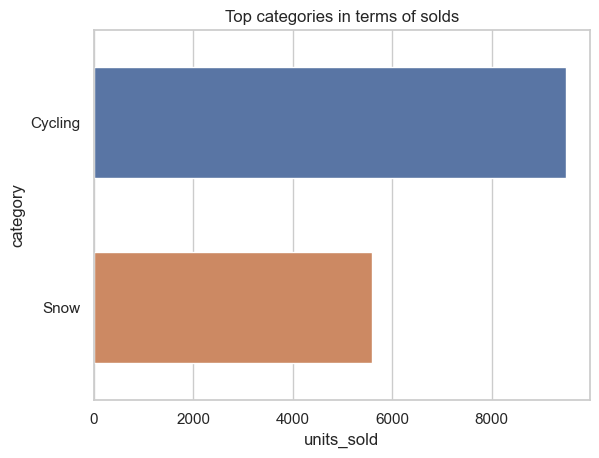

,category,units_sold
0,Cycling,9501
1,Snow,5600


Percentage of sales by product category:
category
Cycling    62.92%
Snow       37.08%
Name: units_sold, dtype: object




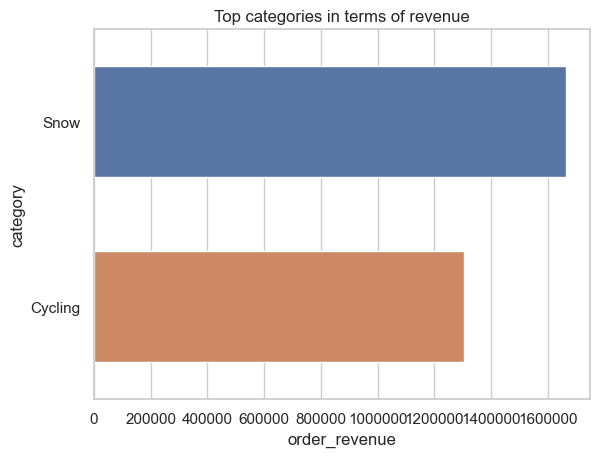

,category,order_revenue
1,Snow,1664940
0,Cycling,1305660


Percentage of revenue by product category:
category
Snow       56.05%
Cycling    43.95%
Name: order_revenue, dtype: object




In [426]:
#2023 sales by category
sns.barplot(x='units_sold', y='category', width= 0.6,errorbar=None, data=order_df[order_df.year>2022].groupby('category')['units_sold'].sum().reset_index().sort_values(
                                                                    by='units_sold', ascending=False))
plt.title('Top categories in terms of solds')
plt.show()

display(order_df[order_df.year>2022].groupby('category')['units_sold'].sum().reset_index().sort_values(by='units_sold', ascending=False))

sales_by_category = order_df[order_df.year>2022].groupby('category')['units_sold'].sum()
percent_sales_by_category = ((sales_by_category / sales_by_category.sum()) * 100).sort_values(ascending=False)
percent_sales_by_category = percent_sales_by_category.apply(lambda x: "{:.2f}%".format(x))
print("Percentage of sales by product category:")
print(percent_sales_by_category)


print("\n")

#revenue by category
sns.barplot(x='order_revenue', y='category',width= 0.6,errorbar=None,data=order_df[order_df.year>2022].groupby('category')['order_revenue'].sum().reset_index().sort_values(
    by='order_revenue', ascending=False))
plt.title('Top categories in terms of revenue')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

display(order_df[order_df.year>2022].groupby('category')['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False))

revenue_by_category = order_df[order_df.year>2022].groupby('category')['order_revenue'].sum()
percent_revenue_by_category = ((revenue_by_category / revenue_by_category.sum()) * 100).sort_values(ascending=False)
percent_revenue_by_category = percent_revenue_by_category.apply(lambda x: "{:.2f}%".format(x))
print("Percentage of revenue by product category:")
print(percent_revenue_by_category)
print("\n")

#### What are the highest selling and highest revenue generating products?

In [411]:
# top products
a=order_df.groupby(['product_name','category'])['units_sold'].sum().reset_index().sort_values(by='units_sold', ascending=False)
print(a.reset_index(drop=True))
print("\n")
b=order_df.groupby(['product_name','category'])['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False)
percentwise=order_df.groupby(['product_name','category'])['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False)
b['order_revenue']=b['order_revenue'].map(lambda x: f'{x:,}')
print(b.reset_index(drop=True))
print("\n")

percentwise['percent']= (percentwise['order_revenue'] / percentwise['order_revenue'].sum()) * 100
print(percentwise.reset_index(drop=True))
print("\n")

revenue_by_top3 = percentwise.nlargest(3, ['percent'])['percent'].sum()

print(f"revneue genrated by top 3 products alone in %: {revenue_by_top3:.2f}")

                product_name category  units_sold
0   M'S Reform Enduro Jersey  Cycling        3514
1         M'S Essential Road  Cycling        3303
2        M'S Coalesce Jacket     Snow        2589
3        Essential Road Sock  Cycling        2246
4             M'S Loft Parka     Snow        1948
5           Vpd System Torso  Cycling        1154
6         Joint Vpd 2.0 Knee  Cycling        1152
7           Kortal Race Mips  Cycling        1120
8           Otocon Race Mips  Cycling        1115
9              Omne Air Mips  Cycling        1105
10       Joint Vpd 2.0 Elbow  Cycling        1102
11                     Nexal     Snow         714
12              Obex Bc Mips     Snow         697
13                    Fornix     Snow         696
14                    Zonula     Snow         689
15                     Fovea     Snow         655
16              Levator Mips     Snow         651
17            Meninx Rs Mips     Snow         567


                product_name category order_reve

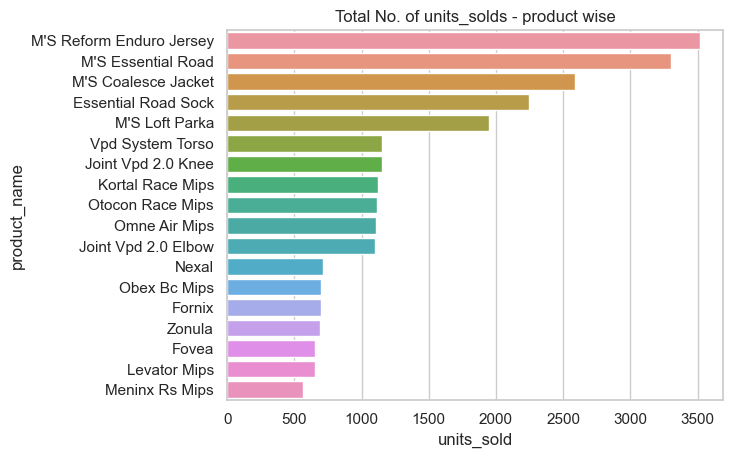

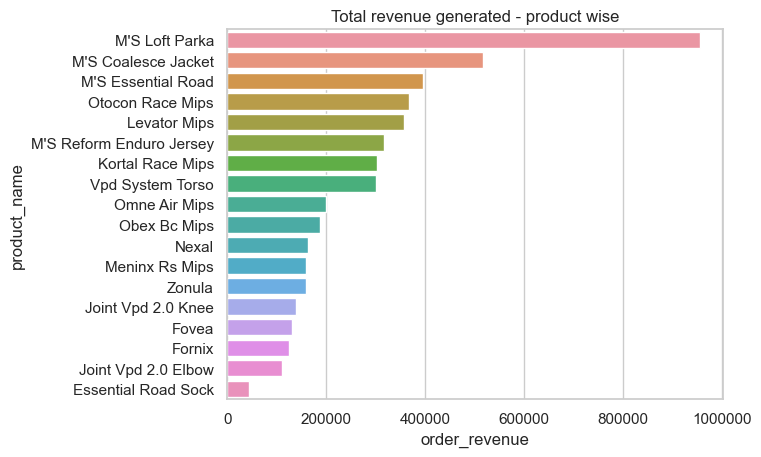

In [436]:
### Total two year trends

sns.barplot(x='units_sold', y='product_name', errorbar=None, data=order_df.groupby(['product_name'])['units_sold'].sum().reset_index().sort_values(
                                                                    by='units_sold', ascending=False))
plt.title('Total No. of units_solds - product wise')
plt.show()

print("\n")
sns.barplot(x='order_revenue', y='product_name', errorbar=None, data=order_df.groupby('product_name')['order_revenue'].sum().reset_index().sort_values(
                                                                    by='order_revenue', ascending=False))
plt.title('Total revenue generated - product wise')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

#### What are the highest selling and highest revenue generating products in 2023? Trends for 2023

In [413]:
# top products
a=order_df[order_df.year>2022].groupby(['product_name','category'])['units_sold'].sum().reset_index().sort_values(by='units_sold', ascending=False)
print(a.reset_index(drop=True))
print("\n")
b=order_df[order_df.year>2022].groupby(['product_name','category'])['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False)
percentwise=order_df[order_df.year>2022].groupby(['product_name','category'])['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False)
b['order_revenue']=b['order_revenue'].map(lambda x: f'{x:,}')
print(b.reset_index(drop=True))
print("\n")

percentwise['percent']= (percentwise['order_revenue'] / percentwise['order_revenue'].sum()) * 100
print(percentwise.reset_index(drop=True))
print("\n")
revenue_top3_2023=percentwise.nlargest(3, ['percent'])['percent'].sum()
print(f"revneue genrated by top 3 products in 2023 in % : {revenue_top3_2023:.2f}")

                product_name category  units_sold
0   M'S Reform Enduro Jersey  Cycling        2195
1         M'S Essential Road  Cycling        2045
2        M'S Coalesce Jacket     Snow        1547
3        Essential Road Sock  Cycling        1305
4             M'S Loft Parka     Snow        1149
5           Vpd System Torso  Cycling         700
6           Otocon Race Mips  Cycling         682
7         Joint Vpd 2.0 Knee  Cycling         680
8              Omne Air Mips  Cycling         658
9           Kortal Race Mips  Cycling         623
10       Joint Vpd 2.0 Elbow  Cycling         613
11                    Fornix     Snow         475
12                     Nexal     Snow         463
13              Obex Bc Mips     Snow         435
14                    Zonula     Snow         423
15              Levator Mips     Snow         396
16                     Fovea     Snow         392
17            Meninx Rs Mips     Snow         320


                product_name category order_reve

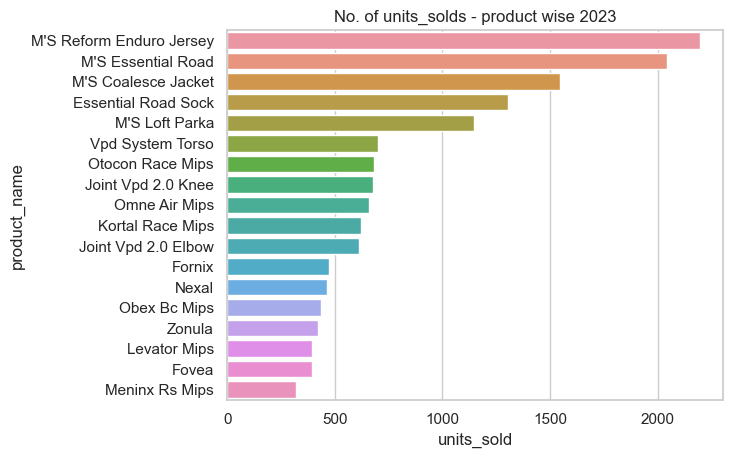

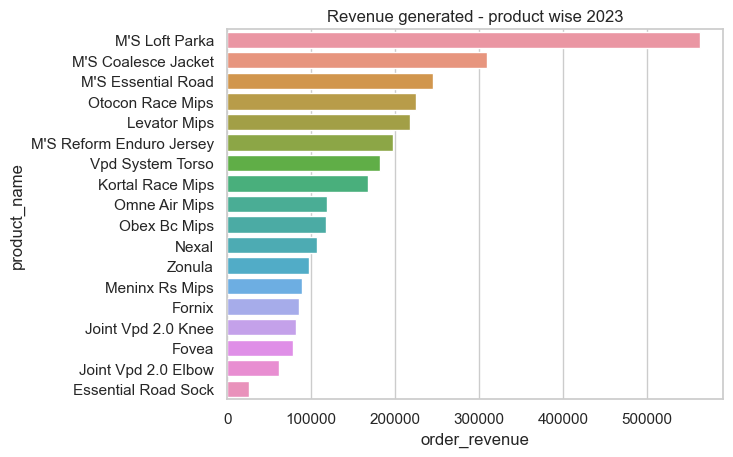

In [428]:
sns.barplot(x='units_sold', y='product_name', errorbar=None, data=order_df[order_df.year>2022].groupby(['product_name'])['units_sold'].sum().reset_index().sort_values(
                                                                    by='units_sold', ascending=False))
plt.title('No. of units_solds - product wise 2023')
plt.show()

print("\n")
sns.barplot(x='order_revenue', y='product_name', errorbar=None, data=order_df[order_df.year>2022].groupby('product_name')['order_revenue'].sum().reset_index().sort_values(
                                                                    by='order_revenue', ascending=False))
plt.title(('Revenue generated - product wise 2023'))
plt.ticklabel_format(style='plain', axis='x')
plt.show()

#### What are the highest selling and highest revenue generating groups?

,group,units_sold
0,Apparel,13600
3,Helmets,5951
1,Armor,3408
2,Goggles,2058


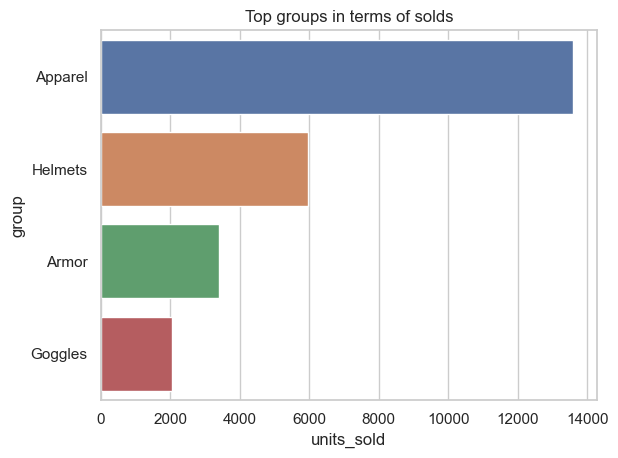

,group,order_revenue
0,Apparel,2229860
3,Helmets,1699530
1,Armor,548480
2,Goggles,453690


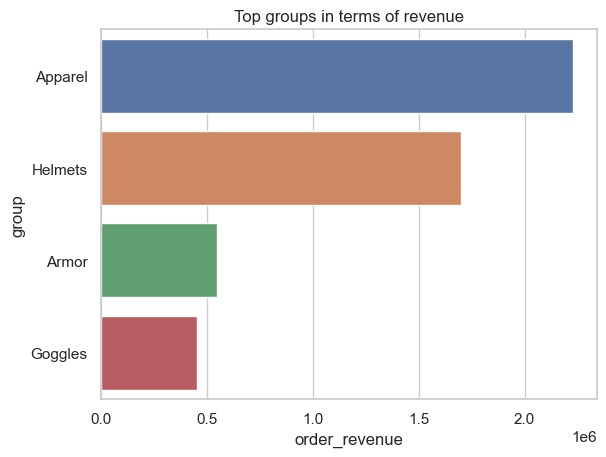

In [414]:
# top groups in terms of revenue and sales

display(order_df.groupby('group')['units_sold'].sum().reset_index().sort_values(by='units_sold', ascending=False))
sns.barplot(x='units_sold', y='group', errorbar=None, data=order_df.groupby('group')['units_sold'].sum().reset_index().sort_values(
                                                                    by='units_sold', ascending=False))
plt.title('Top groups in terms of solds')
plt.show()
print("\n")
display(order_df.groupby('group')['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False))
sns.barplot(x='order_revenue', y='group', errorbar=None, data=order_df.groupby('group')['order_revenue'].sum().reset_index().sort_values(
    by='order_revenue', ascending=False))
plt.title('Top groups in terms of revenue')
plt.show()

#### revenue and sale analysis by countries

,country_name,units_sold
4,UK,8163
1,Germany,7305
3,Sweden,3728
2,Italy,3342
0,Austria,2479


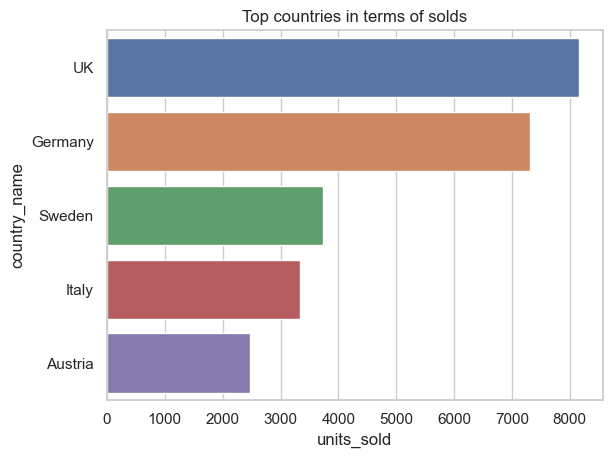

sum                               mean                       \
country_name Austria Germany Italy Sweden    UK Austria Germany Italy Sweden   
category                                                                       
Cycling         1531    4469  2132   2374  5305    2.51    2.48  2.50   2.48   
Snow             948    2836  1210   1354  2858    2.46    2.49  2.57   2.48   

                    count                             
country_name   UK Austria Germany Italy Sweden    UK  
category                                              
Cycling      2.54     611    1801   854    959  2090  
Snow         2.49     385    1138   471    545  1146

In [429]:
display(order_df.groupby('country_name')['units_sold'].sum().reset_index().sort_values(by='units_sold', ascending=False))
sns.barplot(x='units_sold', y='country_name', errorbar=None, data=order_df.groupby('country_name')['units_sold'].sum().reset_index().sort_values(
    by='units_sold', ascending=False))
plt.title('Top countries in terms of solds')
plt.show()

print("\n")

pd.set_option("display.float_format", "{:,.2f}".format)
order_df.pivot_table(
values="units_sold", index="category",
columns="country_name", aggfunc=["sum","mean","count"])


,country_name,order_revenue
4,UK,1595870
1,Germany,1445110
3,Sweden,730700
2,Italy,664190
0,Austria,495690


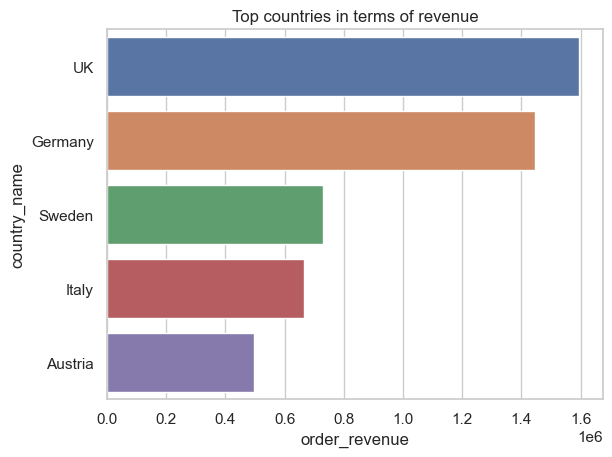

sum                                    mean                 \
country_name Austria Germany   Italy  Sweden      UK Austria Germany  Italy   
category                                                                      
Cycling       206950  607900  288060  327790  744570  338.71  337.53 337.31   
Snow          288740  837210  376130  402910  851300  749.97  735.69 798.58   

                             count                             
country_name Sweden     UK Austria Germany Italy Sweden    UK  
category                                                       
Cycling      341.80 356.25     611    1801   854    959  2090  
Snow         739.28 742.84     385    1138   471    545  1146

In [430]:
display(order_df.groupby('country_name')['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False))
sns.barplot(x='order_revenue', y='country_name', errorbar=None, data=order_df.groupby('country_name')['order_revenue'].sum().reset_index().sort_values(
    by='order_revenue', ascending=False))
plt.title('Top countries in terms of revenue')
plt.show()

print("\n")

pd.set_option("display.float_format", "{:,.2f}".format)
order_df.pivot_table(
values="order_revenue", index="category",
columns="country_name", aggfunc=["sum","mean","count"])

#### Country_wise revenue trends for 2023

,country_name,order_revenue
4,UK,979350
1,Germany,848370
3,Sweden,427390
2,Italy,416770
0,Austria,298720


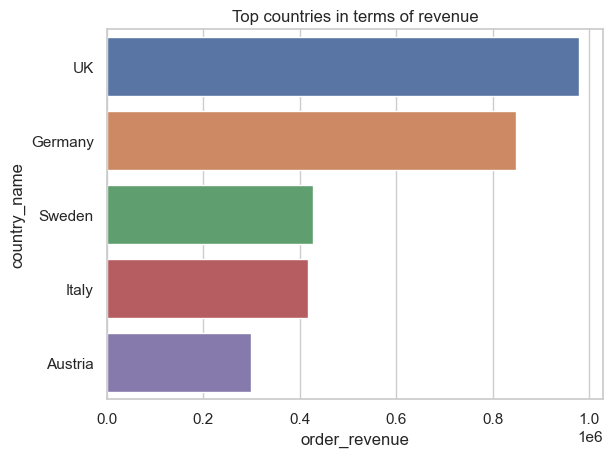

sum                                    mean                 \
country_name Austria Germany   Italy  Sweden      UK Austria Germany  Italy   
category                                                                      
Cycling       130220  356470  166790  192170  460010  335.62  338.21 324.49   
Snow          168500  491900  249980  235220  519340  755.61  740.81 844.53   

                             count                             
country_name Sweden     UK Austria Germany Italy Sweden    UK  
category                                                       
Cycling      340.12 361.64     388    1054   514    565  1272  
Snow         744.37 733.53     223     664   296    316   708

In [431]:

display(order_df[order_df.year>2022].groupby('country_name')['order_revenue'].sum().reset_index().sort_values(by='order_revenue', ascending=False))
sns.barplot(x='order_revenue', y='country_name', errorbar=None, data=order_df[order_df.year>2022].groupby('country_name')['order_revenue'].sum().reset_index().sort_values(
    by='order_revenue', ascending=False))
plt.title('Top countries in terms of revenue')
plt.show()

print("\n")

pd.set_option("display.float_format", "{:,.2f}".format)
order_df[order_df.year>2022].pivot_table(
values="order_revenue", index="category",
columns="country_name", aggfunc=["sum","mean","count"])

#### popular product categories in each countires

In [69]:
#Most popular product category in each country
popular_category_by_country = order_df.groupby(['country_name', 'category'])['units_sold'].sum().reset_index()
popular_category_by_country = popular_category_by_country.sort_values(['country_name', 'units_sold'], ascending=[True, False])
popular_category_by_country = popular_category_by_country.drop_duplicates(subset=['country_name'])
print("Most popular product category in each country:")
print(popular_category_by_country)
print("\n")

#Most popular product in each country
popular_category_by_country = order_df.groupby(['country_name', 'product_name'])['units_sold'].sum().reset_index()
popular_category_by_country = popular_category_by_country.sort_values(['country_name', 'product_name'], ascending=[True, False])
popular_category_by_country = popular_category_by_country.drop_duplicates(subset=['country_name'])
print("Most popular product in each country:")
print(popular_category_by_country)
print("\n")


Most popular product category in each country:
  country_name category  units_sold
0      Austria  Cycling        1531
2      Germany  Cycling        4469
4        Italy  Cycling        2132
6       Sweden  Cycling        2374
8           UK  Cycling        5305


Most popular product in each country:
   country_name product_name  units_sold
17      Austria       Zonula          64
35      Germany       Zonula         198
53        Italy       Zonula          82
71       Sweden       Zonula          67
89           UK       Zonula         278




In [488]:
#Most revenue generating product and category in each country
revenue_popular_category_by_country = order_df.groupby(['country_name', 'category'])['order_revenue'].sum().reset_index()
revenue_popular_category_by_country = revenue_popular_category_by_country.sort_values(['country_name', 'order_revenue'], ascending=[True, False])
revenue_popular_category_by_country = revenue_popular_category_by_country.drop_duplicates(subset=['country_name'])
print("Most revenue generating product category in each country:")
print(revenue_popular_category_by_country)
print("\n")

#Most popular product in each country
revenue_popular_product_by_country = order_df.groupby(['country_name', 'product_name'])['order_revenue'].sum().reset_index()
revenue_popular_product_by_country = revenue_popular_product_by_country.sort_values(['country_name', 'product_name'], ascending=[True, False])
revenue_popular_product_by_country = revenue_popular_product_by_country.drop_duplicates(subset=['country_name'])
print("Most revenue generating product in each country:")
print(revenue_popular_product_by_country)
print("\n")

Most revenue generating product category in each country:
  country_name category  order_revenue
1      Austria     Snow         288740
3      Germany     Snow         837210
5        Italy     Snow         376130
7       Sweden     Snow         402910
9           UK     Snow         851300


Most revenue generating product in each country:
   country_name product_name  order_revenue
17      Austria       Zonula          14720
35      Germany       Zonula          45540
53        Italy       Zonula          18860
71       Sweden       Zonula          15410
89           UK       Zonula          63940




#### Analysis of Sales and Revenue trends by month

In [233]:

sales_trends = order_df.groupby(['year', 'month'])['units_sold'].sum().reset_index()
revenue_trends = order_df.groupby(['year', 'month'])['order_revenue'].sum().reset_index()
revenue_trends

/var/folders/kc/vbh30fpj45j8gf55k5hl7vbr0000gn/T/ipykernel_5284/1504017606.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_trends = order_df.groupby(['year', 'month'])['units_sold'].sum().reset_index()
/var/folders/kc/vbh30fpj45j8gf55k5hl7vbr0000gn/T/ipykernel_5284/1504017606.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_trends = order_df.groupby(['year', 'month'])['order_revenue'].sum().reset_index()


,year,month,order_revenue
0,2022,january,207250
1,2022,february,193740
2,2022,march,150240
3,2022,april,185180
4,2022,may,196260
5,2022,june,147850
6,2022,july,146490
7,2022,august,147930
8,2022,september,151180
9,2022,october,138720


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


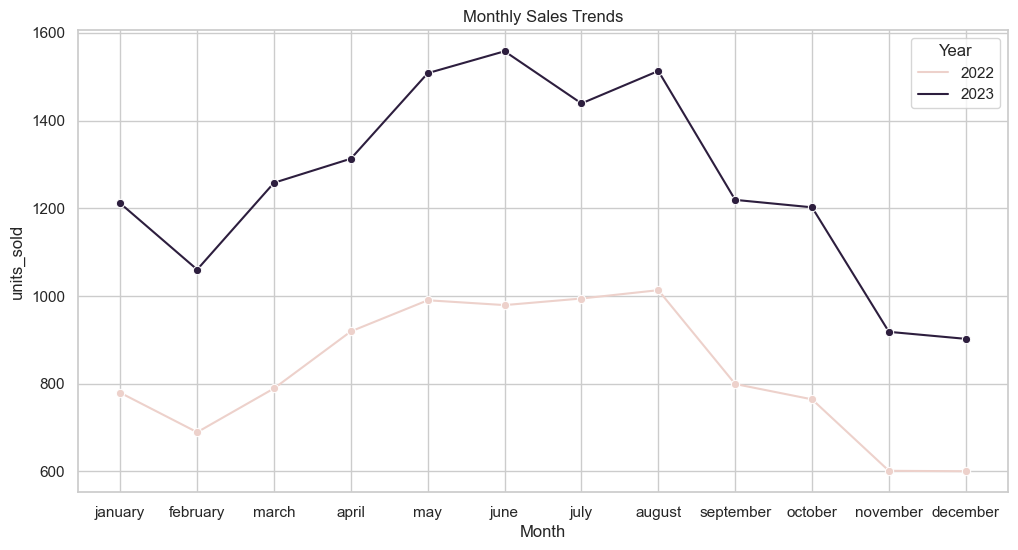

In [416]:
# Line plot for revenue Trends by Month
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_trends, x='month', y='units_sold', hue='year', marker='o')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('units_sold')
plt.legend(title='Year')
plt.savefig('sales.png')
# plt.savefig('sales.png')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


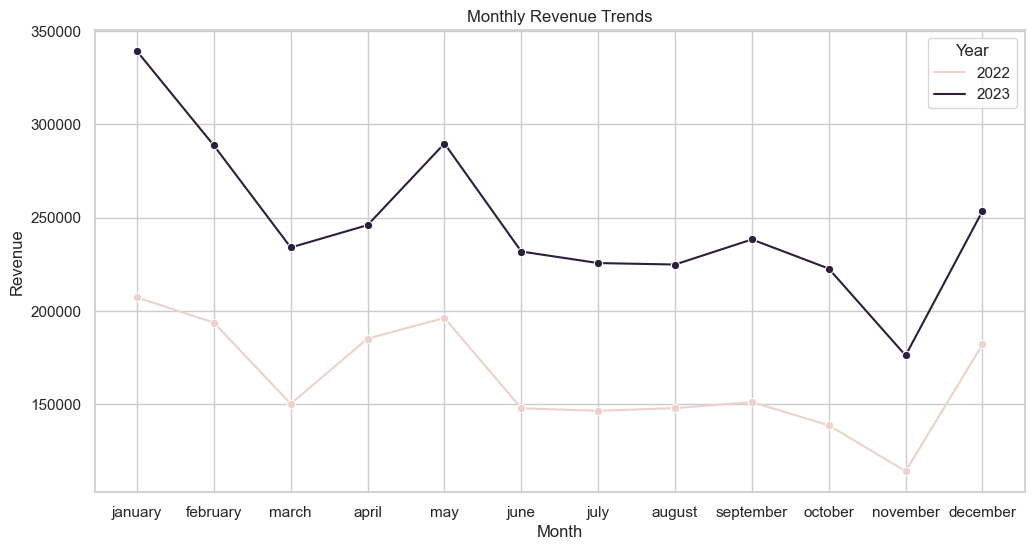

In [417]:
# Line plot for Sales Trends by Month
plt.figure(figsize=(12, 6))
sns.lineplot(data=revenue_trends, x='month', y='order_revenue', hue='year', marker='o')
plt.title('Monthly Revenue Trends')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend(title='Year')
# plt.savefig('revenue.png')
plt.show()


,growth_rate in %
month,
january,63.65
february,48.99
march,32.50
april,32.84
may,47.62
june,56.81
july,54.04
august,52.01
september,57.64


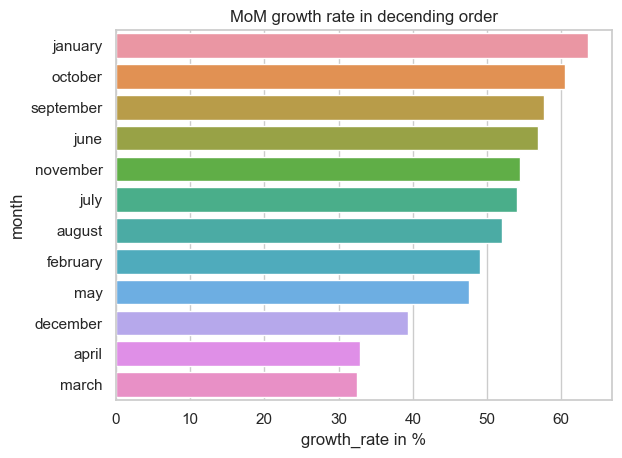

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


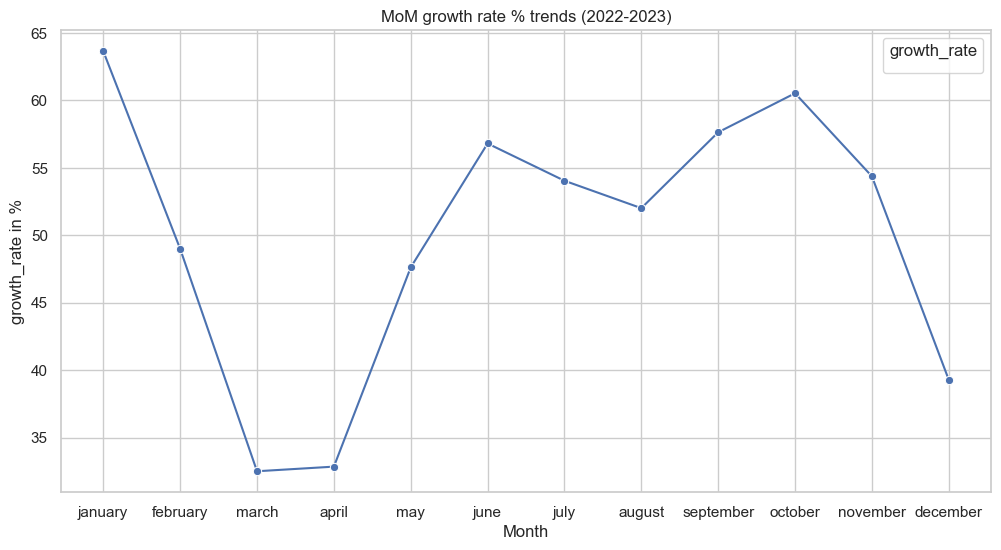

In [425]:
# revenue_by_month = order_df.groupby(['year','month'], observed=False)['order_revenue'].sum()
revenue_by_month = pd.DataFrame(order_df.groupby(['year','month'], observed=False)['order_revenue'].sum())

growth_mom_jan = ((revenue_by_month.loc[(2023,"january")] - revenue_by_month.loc[(2022,"january")]) / revenue_by_month.loc[(2022,"january")]) * 100
growth_mom_feb = ((revenue_by_month.loc[(2023,"february")] - revenue_by_month.loc[(2022,"february")]) / revenue_by_month.loc[(2022,"february")]) * 100
growth_mom_mar = ((revenue_by_month.loc[(2023,"march")] - revenue_by_month.loc[(2022,"april")])/ revenue_by_month.loc[(2022,"march")]) * 100
growth_mom_apr = ((revenue_by_month.loc[(2023,"april")] - revenue_by_month.loc[(2022,"april")]) / revenue_by_month.loc[(2022,"april")]) * 100
growth_mom_may = ((revenue_by_month.loc[(2023,"may")] - revenue_by_month.loc[(2022,"may")]) / revenue_by_month.loc[(2022,"may")]) * 100
growth_mom_jun = ((revenue_by_month.loc[(2023,"june")] - revenue_by_month.loc[(2022,"june")])/ revenue_by_month.loc[(2022,"june")]) * 100
growth_mom_jul = ((revenue_by_month.loc[(2023,"july")] - revenue_by_month.loc[(2022,"july")]) / revenue_by_month.loc[(2022,"july")]) * 100
growth_mom_aug = ((revenue_by_month.loc[(2023,"august")] - revenue_by_month.loc[(2022,"august")]) / revenue_by_month.loc[(2022,"august")]) * 100
growth_mom_sep = ((revenue_by_month.loc[(2023,"september")] - revenue_by_month.loc[(2022,"september")]) / revenue_by_month.loc[(2022,"september")]) * 100
growth_mom_oct = ((revenue_by_month.loc[(2023,"october")] - revenue_by_month.loc[(2022,"october")]) / revenue_by_month.loc[(2022,"october")]) * 100
growth_mom_nov = ((revenue_by_month.loc[(2023,"november")] - revenue_by_month.loc[(2022,"november")]) / revenue_by_month.loc[(2022,"november")]) * 100
growth_mom_dec = ((revenue_by_month.loc[(2023,"december")] - revenue_by_month.loc[(2022,"december")]) / revenue_by_month.loc[(2022,"december")]) * 100

growth_mom=[growth_mom_jan,growth_mom_feb,growth_mom_mar,growth_mom_apr,growth_mom_may,growth_mom_jun,growth_mom_jul,growth_mom_aug,growth_mom_sep,growth_mom_oct,growth_mom_nov,growth_mom_dec]
growth_df=pd.DataFrame(growth_mom)
growth_df.rename(columns={'order_revenue': 'growth_rate in %'}, inplace=True)
growth_df['month']=month_order
growth_df1=growth_df.set_index('month', inplace=False)
display(growth_df1)

print("\n")

sns.barplot(x='growth_rate in %', y='month',errorbar=None, data=growth_df.sort_values(by='growth_rate in %', ascending=False))
plt.title('MoM growth rate in decending order')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

print("\n")

plt.figure(figsize=(12, 6))
sns.lineplot(data=growth_df, x='month', y='growth_rate in %', marker='o')
plt.title('MoM growth rate % trends (2022-2023)')
plt.xlabel('Month')
plt.ylabel('growth_rate in %')
plt.legend(title='growth_rate')
# plt.savefig('sales.png')
plt.show()

,growth_rate in %
quarter,
Q1,56.35
Q2,45.02
Q3,54.59
Q4,50.02


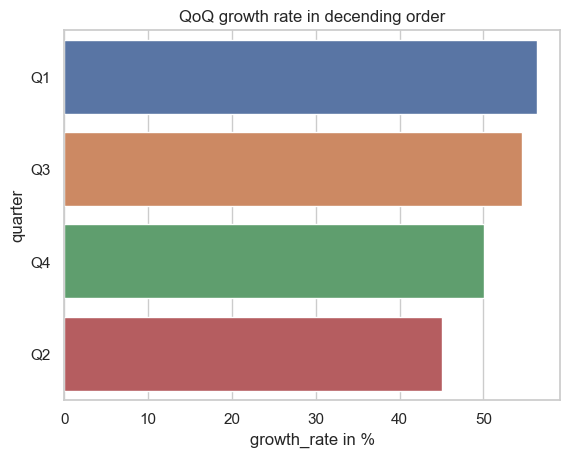

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


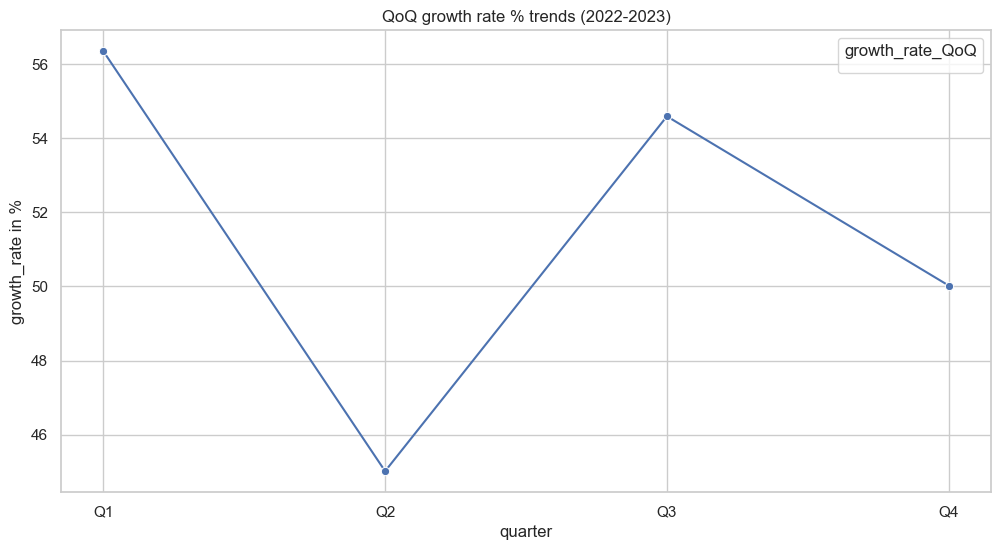

In [443]:
#QoQ growth rate analysis

quarter=['Q1','Q2','Q3','Q4']
revenue_q1_2022 = (revenue_by_month.loc[(2022,"january")] + revenue_by_month.loc[(2022,"february")]+ revenue_by_month.loc[(2022,"march")])
revenue_q2_2022 = (revenue_by_month.loc[(2022,"april")] + revenue_by_month.loc[(2022,"may")]+ revenue_by_month.loc[(2022,"june")])
revenue_q3_2022 = (revenue_by_month.loc[(2022,"july")] + revenue_by_month.loc[(2022,"august")]+ revenue_by_month.loc[(2022,"september")])
revenue_q4_2022 = (revenue_by_month.loc[(2022,"october")] + revenue_by_month.loc[(2022,"november")]+ revenue_by_month.loc[(2022,"december")])
revenue_q1_2023 = (revenue_by_month.loc[(2023,"january")] + revenue_by_month.loc[(2023,"february")]+ revenue_by_month.loc[(2023,"march")])
revenue_q2_2023 = (revenue_by_month.loc[(2023,"april")] + revenue_by_month.loc[(2023,"may")]+ revenue_by_month.loc[(2023,"june")])
revenue_q3_2023 = (revenue_by_month.loc[(2023,"july")] + revenue_by_month.loc[(2023,"august")]+ revenue_by_month.loc[(2023,"september")])
revenue_q4_2023 = (revenue_by_month.loc[(2023,"october")] + revenue_by_month.loc[(2023,"november")]+ revenue_by_month.loc[(2023,"december")])

revenue_growth_rate_q1 = ((revenue_q1_2023 - revenue_q1_2022) / revenue_q1_2022) * 100
revenue_growth_rate_q2 = ((revenue_q2_2023 - revenue_q2_2022) / revenue_q2_2022) * 100
revenue_growth_rate_q3 = ((revenue_q3_2023 - revenue_q3_2022) / revenue_q3_2022) * 100
revenue_growth_rate_q4 = ((revenue_q4_2023 - revenue_q4_2022) / revenue_q4_2022) * 100
growth_qoq=[revenue_growth_rate_q1,revenue_growth_rate_q2,revenue_growth_rate_q3,revenue_growth_rate_q4]
growth_qoq_df=pd.DataFrame(growth_qoq)
growth_qoq_df.rename(columns={'order_revenue': 'growth_rate in %'}, inplace=True)
growth_qoq_df['quarter']= quarter
growth_qoq_df1=growth_qoq_df.set_index('quarter',inplace=False)
display(growth_qoq_df1)



print("\n")

sns.barplot(x='growth_rate in %', y='quarter',errorbar=None, data=growth_qoq_df.sort_values(by='growth_rate in %', ascending=False))
plt.title('QoQ growth rate in decending order')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

print("\n")

plt.figure(figsize=(12, 6))
sns.lineplot(data=growth_qoq_df, x='quarter', y='growth_rate in %', marker='o')
plt.title('QoQ growth rate % trends (2022-2023)')
plt.xlabel('quarter')
plt.ylabel('growth_rate in %')
plt.legend(title='growth_rate_QoQ')
# plt.savefig('sales.png')
plt.show()

In [444]:

order_df_2022 = order_df[order_df['year'] == 2022]
order_df_2023 = order_df[order_df['year'] == 2023]

# Group the data by category and quarter to calculate total revenue for each quarter in each year
revenue_2022 = order_df_2022.groupby(['category', 'quarter'])['order_revenue'].sum().reset_index()
revenue_2023 = order_df_2023.groupby(['category', 'quarter'])['order_revenue'].sum().reset_index()

# Merge the data for 2022 and 2023 to align the quarters for comparison
revenue_comparison = pd.merge(revenue_2022, revenue_2023, on=['category', 'quarter'], suffixes=('_2022', '_2023'))

# Calculate the quarter-on-quarter growth for each category
revenue_comparison['QoQ_growth'] = ((revenue_comparison['order_revenue_2023'] - revenue_comparison['order_revenue_2022']) / 
                                    revenue_comparison['order_revenue_2022']) * 100

# Display the results
print(revenue_comparison[['category', 'quarter', 'order_revenue_2022', 'order_revenue_2023', 'QoQ_growth']])


  category  quarter  order_revenue_2022  order_revenue_2023  QoQ_growth
0  Cycling        1              102890              175080       70.16
1  Cycling        2              301980              443940       47.01
2  Cycling        3              328550              476110       44.91
3  Cycling        4              136190              210530       54.59
4     Snow        1              448340              686750       53.18
5     Snow        2              227310              323620       42.37
6     Snow        3              117050              212740       81.75
7     Snow        4              298650              441830       47.94


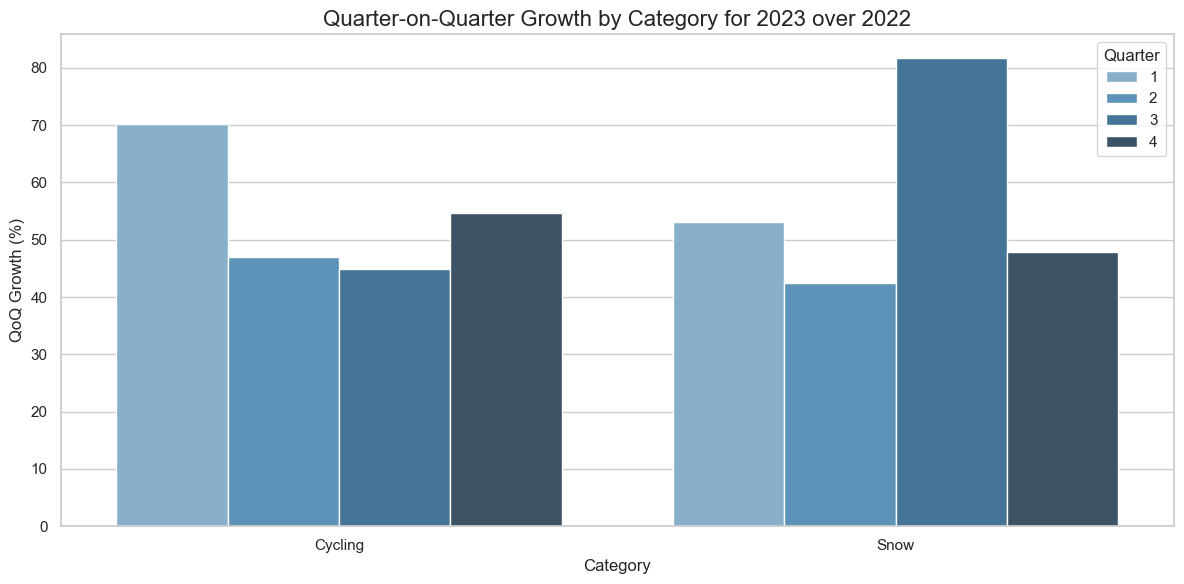

In [446]:

revenue_comparison['quarter'] = revenue_comparison['quarter'].astype(str)

# Visualize QoQ Growth for each category
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='QoQ_growth', hue='quarter', data=revenue_comparison, palette='Blues_d')
plt.title('Quarter-on-Quarter Growth by Category for 2023 over 2022', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('QoQ Growth (%)', fontsize=12)
plt.legend(title='Quarter', loc='upper right')
plt.tight_layout()
plt.show()

#### Analysis of Average order Value

Overall AOV 493.156


Overall AOV by country   country_name    AOV
0      Austria 497.68
1      Germany 491.70
2        Italy 501.28
3       Sweden 485.84
4           UK 493.16


Overall AOV by category   category    AOV
0  Cycling 344.46
1     Snow 747.98


Overall AOV 2022 490.24


Overall AOV 2023 495.1


AOV by country for 2022   country_name    AOV
0      Austria 511.61
1      Germany 488.73
2        Italy 480.43
3       Sweden 486.85
4           UK 490.86


AOV by country for 2023   country_name    AOV
0      Austria 488.90
1      Germany 493.81
2        Italy 514.53
3       Sweden 485.12
4           UK 494.62


AOV by country for 2022   category    AOV
0  Cycling 344.81
1     Snow 738.40


AOV by country for 2023   category    AOV
0  Cycling 344.23
1     Snow 754.39


percentage of orders greater than AOV: 35.34
percentage of orders greater than AOV 2023: 35.65


Percentage of Orders Greater Than AOV by Country:
  country_name  percentage_greater_than_aov
0      Austria         

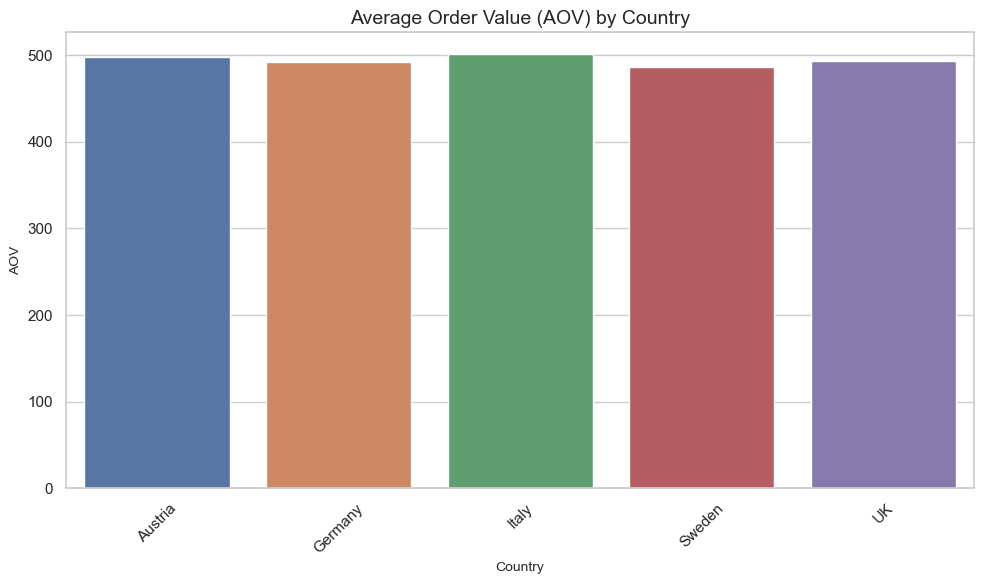

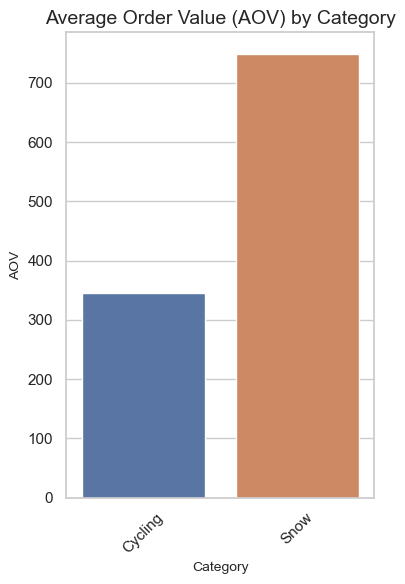

In [387]:
#Average order Value


# Setting visual properties
sns.set(style='whitegrid')

# Overall

total_aov=order_df['order_revenue'].mean()
print("Overall AOV",total_aov)
print("\n")
aov_country = order_df.groupby('country_name')['order_revenue'].mean().reset_index(name='AOV')
print("Overall AOV by country",aov_country)
print("\n")
aov_category = order_df.groupby('category')['order_revenue'].mean().reset_index(name='AOV')
print("Overall AOV by category",aov_category)
print("\n")

# AOV calculation for the year 2023
order_df_2022 = order_df[order_df['year'] == 2022]

total_aov_2022=order_df_2022['order_revenue'].mean()
print("Overall AOV 2022",total_aov_2022)
print("\n")

order_df_2023 = order_df[order_df['year'] == 2023]

total_aov_2023=order_df_2023['order_revenue'].mean()
print("Overall AOV 2023",total_aov_2023)
print("\n")

aov_country_2022 = order_df_2022.groupby('country_name')['order_revenue'].mean().reset_index(name='AOV')
print("AOV by country for 2022",aov_country_2022)
print("\n")

aov_country_2023 = order_df_2023.groupby('country_name')['order_revenue'].mean().reset_index(name='AOV')
print("AOV by country for 2023",aov_country_2023)
print("\n")

aov_category_2022 = order_df_2022.groupby('category')['order_revenue'].mean().reset_index(name='AOV')
print("AOV by country for 2022",aov_category_2022)
print("\n")
aov_category_2023 = order_df_2023.groupby('category')['order_revenue'].mean().reset_index(name='AOV')
print("AOV by country for 2023",aov_category_2023)
print("\n")
# percentage of orders greater than AOV
orders_greater_than_aov = order_df[order_df['order_revenue'] > order_df['order_revenue'].mean()].shape[0]
orders_greater_aov_percent = (orders_greater_than_aov/order_df['id'].nunique())*100
print(f"percentage of orders greater than AOV: {orders_greater_aov_percent:.2f}")

# percentage of orders greater than AOV in 2023
orders_greater_aov_2023 = order_df_2023[order_df_2023['order_revenue'] > order_df_2023['order_revenue'].mean()].shape[0]
orders_greater_aov_percent_2023 = (orders_greater_than_aov_2023/order_df_2023['id'].nunique())*100

print(f"percentage of orders greater than AOV 2023: {orders_greater_aov_percent_2023:.2f}")

print("\n")


# new column to identify orders greater than AOV
order_df['orders_greater_than_aov'] = order_df['order_revenue'] > total_aov

# percentage of orders greater than AOV by country
orders_by_country = order_df.groupby('country_name').agg(
    total_orders=('order_revenue', 'count'),
    orders_greater_than_aov=('orders_greater_than_aov', 'sum')
).reset_index()

orders_by_country['percentage_greater_than_aov'] = (orders_by_country['orders_greater_than_aov'] / orders_by_country['total_orders']) * 100

# percentage of orders greater than AOV by category
orders_by_category = order_df.groupby('category').agg(
    total_orders=('order_revenue', 'count'),
    orders_greater_than_aov=('orders_greater_than_aov', 'sum')
).reset_index()

orders_by_category['percentage_greater_than_aov'] = (orders_by_category['orders_greater_than_aov'] / orders_by_category['total_orders']) * 100

# Display the results
print("Percentage of Orders Greater Than AOV by Country:")
print(orders_by_country[['country_name', 'percentage_greater_than_aov']])
print("\n")
print("\nPercentage of Orders Greater Than AOV by Category:")
print(orders_by_category[['category', 'percentage_greater_than_aov']])

print("\n")
# Visualization: AOV by Country
plt.figure(figsize=(10, 6))
sns.barplot(x='country_name', y='AOV', data=aov_country)
plt.title('Average Order Value (AOV) by Country', fontsize=14)
plt.xlabel('Country', fontsize=10)
plt.ylabel('AOV', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization: AOV by Category
plt.figure(figsize=(4, 6))
sns.barplot(x='category', y='AOV', data=aov_category)
plt.title('Average Order Value (AOV) by Category', fontsize=14)
plt.xlabel('Category', fontsize=10)
plt.ylabel('AOV', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



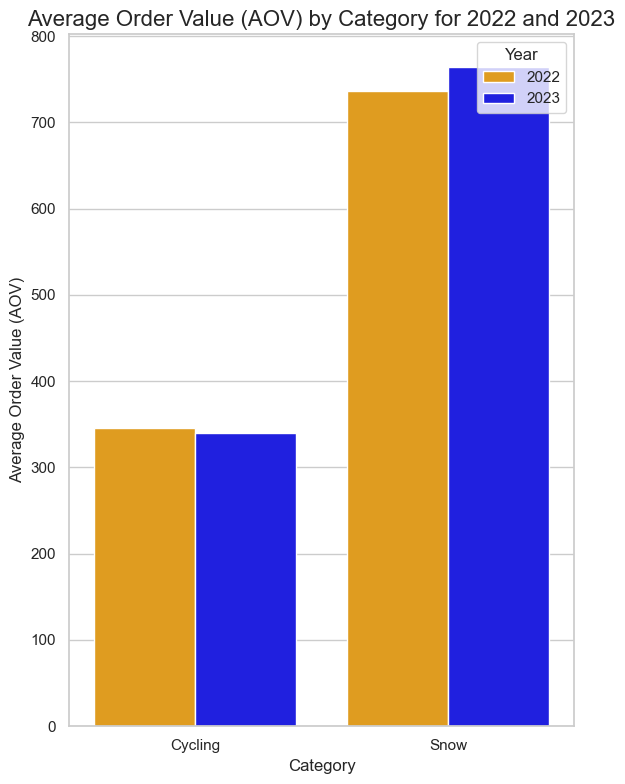

In [448]:

# Visualization of AOV by year, 2022-orange, 2023-blue


aov_2022 = order_df_2022.groupby(['country_name', 'category'])['order_revenue'].mean().reset_index()
aov_2022['year'] = 2022

aov_2023 = order_df_2023.groupby(['country_name', 'category'])['order_revenue'].mean().reset_index()
aov_2023['year'] = 2023

aov_combined = pd.concat([aov_2022, aov_2023])
aov_combined['year']= aov_combined['year'].astype(str)
# bar plot for AOV comparison between categories
plt.figure(figsize=(6, 8))
sns.barplot(x='category', y='order_revenue', hue='year', data=aov_combined, palette=['orange', 'blue'], errorbar=None)
plt.title('Average Order Value (AOV) by Category for 2022 and 2023', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Order Value (AOV)', fontsize=12)
plt.legend(title='Year', loc='upper right')
plt.tight_layout()
plt.show()

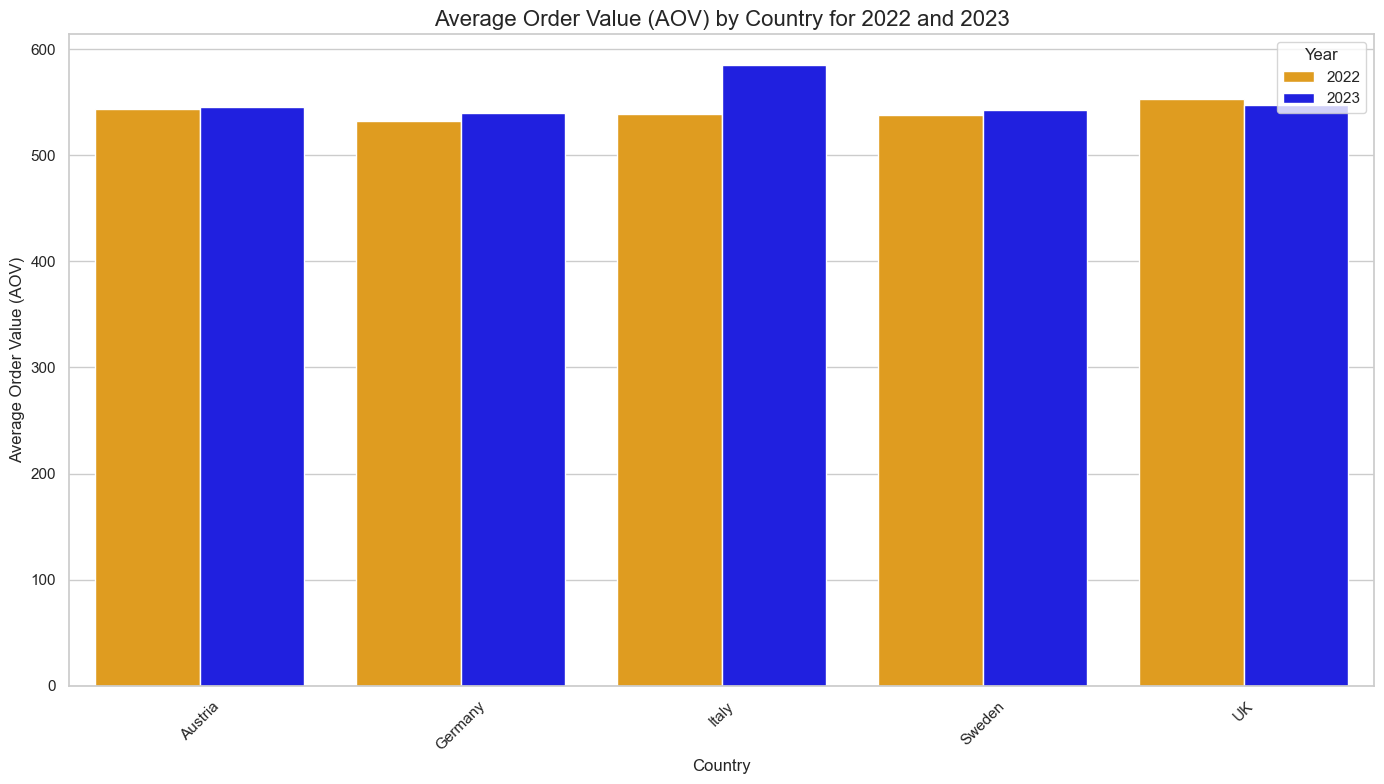

In [449]:
# bar plot for AOV comparison by countries
plt.figure(figsize=(14, 8))
sns.barplot(x='country_name', y='order_revenue', hue='year', data=aov_combined, palette=['orange', 'blue'], errorbar=None)
plt.title('Average Order Value (AOV) by Country for 2022 and 2023', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Average Order Value (AOV)', fontsize=12)
plt.legend(title='Year', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Retention rate and Churn rate analysis

In [389]:
#Filter data for the year 2022 and 2023
customers_2022 = set(order_df[order_df['year'] == 2022]['customer_id'])
customers_2023 = set(order_df[order_df['year'] == 2023]['customer_id'])

# Retention Rate
retained_customers = customers_2022.intersection(customers_2023)
retention_rate = (len(retained_customers) / len(customers_2022)) * 100


# Churn Rate
churned_customers = customers_2022 - customers_2023
churn_rate = (len(churned_customers) / len(customers_2022)) * 100



print(f'Retention Rate: {retention_rate:.2f}%')
print(f'Churn Rate: {churn_rate:.2f}%')


Retention Rate: 99.80%
Churn Rate: 0.20%


#### Retention and churn analysis by category and country

In [400]:

category_customers_2022 = order_df[order_df['year'] == 2022].groupby('category')['customer_id'].unique()
category_customers_2023 = order_df[order_df['year'] == 2023].groupby('category')['customer_id'].unique()

# Retention and Churn Rate by Category
retention_by_category = {}
churn_by_category = {}

for category in category_customers_2022.index:
    customers_2022 = set(category_customers_2022[category])
    customers_2023 = set(category_customers_2023.get(category, []))
    
    retained_customers = len(customers_2022.intersection(customers_2023))
    churned_customers = len(customers_2022 - customers_2023)
    
    retention_by_category[category] = (retained_customers / len(customers_2022)) * 100
    churn_by_category[category] = (churned_customers / len(customers_2022)) * 100
print("retention_by_category in % is:")
print(retention_by_category)

print("\n")

print("churn_by_category in % is:")
print(churn_by_category)
print("\n")


# Step 2: Calculate Retention and Churn by Country
country_customers_2022 = order_df[order_df['year'] == 2022].groupby('country_name')['customer_id'].unique()
country_customers_2023 = order_df[order_df['year'] == 2023].groupby('country_name')['customer_id'].unique()

retention_by_country = {}
churn_by_country = {}

for country in country_customers_2022.index:
    customers_2022 = set(country_customers_2022[country])
    customers_2023 = set(country_customers_2023.get(country, []))
    
    retained_customers = len(customers_2022.intersection(customers_2023))
    churned_customers = len(customers_2022 - customers_2023)
    
    retention_by_country[country] = (retained_customers / len(customers_2022)) * 100
    churn_by_country[country] = (churned_customers / len(customers_2022)) * 100
print("retention_by_country in % is:")
print(retention_by_country)

print("\n")

print("churn_by_country in % is:")
print(churn_by_country)


retention_by_category in % is:
{'Cycling': 98.16414686825054, 'Snow': 87.85166240409207}


churn_by_category in % is:
{'Cycling': 1.8358531317494602, 'Snow': 12.148337595907927}


retention_by_country in % is:
{'Austria': 98.9795918367347, 'Germany': 100.0, 'Italy': 100.0, 'Sweden': 99.33774834437085, 'UK': 100.0}


churn_by_country in % is:
{'Austria': 1.0204081632653061, 'Germany': 0.0, 'Italy': 0.0, 'Sweden': 0.6622516556291391, 'UK': 0.0}


  Category  Retention Rate  Churn Rate
0  Cycling           98.16        1.84
1     Snow           87.85       12.15




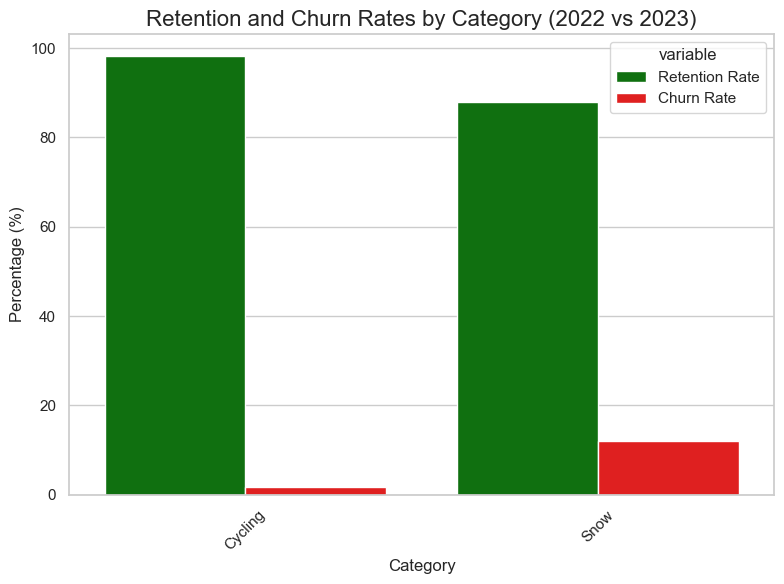

In [355]:
# Data for plotting retention and churn rates by category
category_data = pd.DataFrame({
    'Category': list(retention_by_category.keys()),
    'Retention Rate': list(retention_by_category.values()),
    'Churn Rate': list(churn_by_category.values())
})
print(category_data)
print("\n")

# Plotting retention and churn rates by category
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='value', hue='variable', data=category_data.melt(id_vars='Category'),
            palette=['green', 'red'])
plt.title('Retention and Churn Rates by Category (2022 vs 2023)', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


   Country  Retention Rate  Churn Rate
0  Austria           98.98        1.02
1  Germany          100.00        0.00
2    Italy          100.00        0.00
3   Sweden           99.34        0.66
4       UK          100.00        0.00




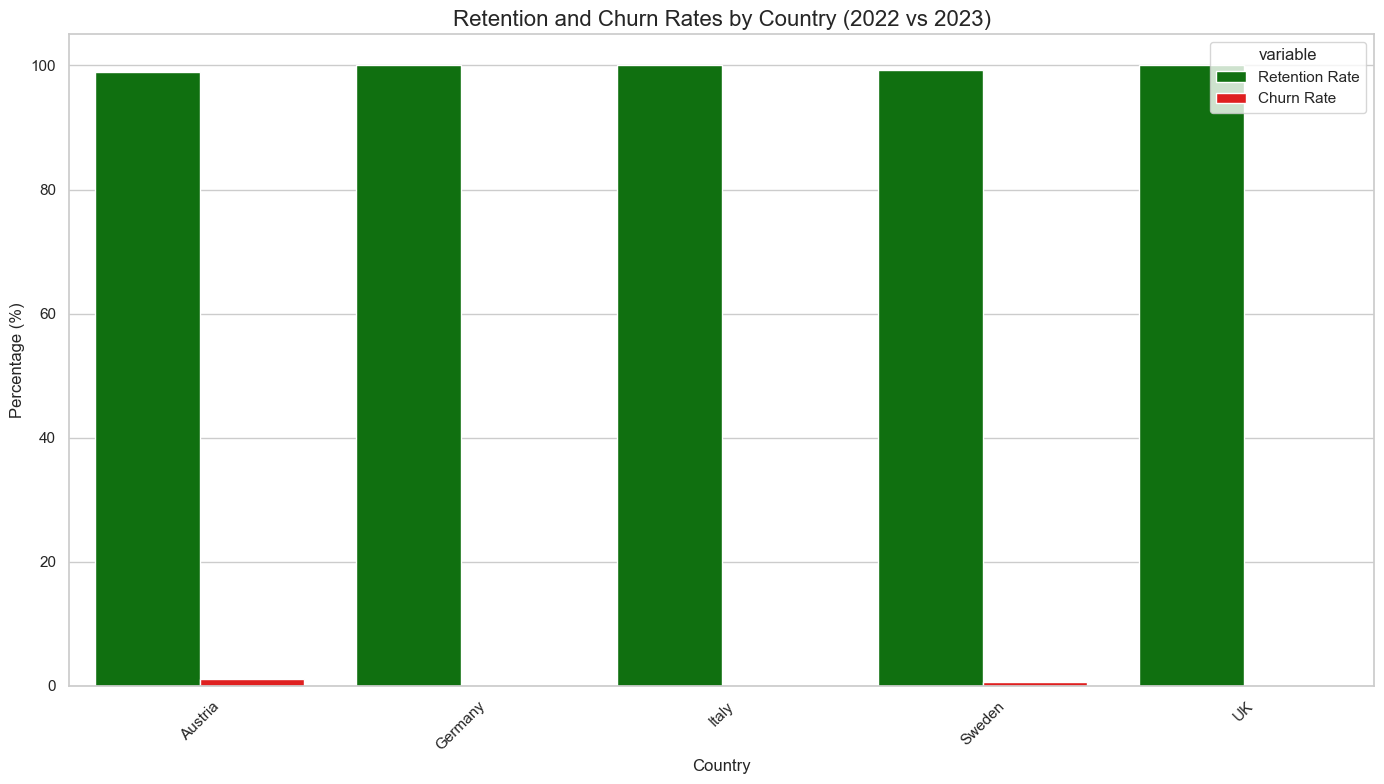

In [351]:
# Data for plotting retention and churn rates by country
country_data = pd.DataFrame({
    'Country': list(retention_by_country.keys()),
    'Retention Rate': list(retention_by_country.values()),
    'Churn Rate': list(churn_by_country.values())
})
print(country_data)
print("\n")
# Plotting retention and churn rates by country
plt.figure(figsize=(14, 8))
sns.barplot(x='Country', y='value', hue='variable', data=country_data.melt(id_vars='Country'),
            palette=['green', 'red'])
plt.title('Retention and Churn Rates by Country (2022 vs 2023)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Re-Purchase Rate Analysis

In [407]:
# 1 Calculate Repurchase Rate (Total)
repeat_customers = order_df['customer_id'].value_counts().loc[lambda x: x > 1].count()
repurchase_rate_total = repeat_customers / unique_customers * 100
print("Re-Purchase rate:")
print(repurchase_rate_total)
print("\n")
# 2 Calculate Repurchase Rate by Category
repurchase_rate_category = order_df.groupby('category')['customer_id'].apply(lambda x: x[x.duplicated()].nunique()).reset_index()
repurchase_rate_category.columns = ['category', 'repeat_customers']
repurchase_rate_category['total_customers'] = order_df.groupby('category')['customer_id'].nunique().values
repurchase_rate_category['repurchase_rate'] = (repurchase_rate_category['repeat_customers'] / repurchase_rate_category['total_customers']) * 100
print("Repurchase rate category wise")
print(repurchase_rate_category)
# # 3 Calculate Repurchase Rate by Country
# repurchase_rate_country = order_df.groupby('country_name')['customer_id'].apply(lambda x: x[x.duplicated()].nunique()).reset_index()
# repurchase_rate_country.columns = ['country_name', 'repeat_customers']
# repurchase_rate_country['total_customers'] = order_df.groupby('country_name')['customer_id'].nunique().values
# repurchase_rate_country['repurchase_rate'] = (repurchase_rate_country['repeat_customers'] / repurchase_rate_country['total_customers']) * 100
# print(repurchase_rate_country)


# this shows that customers are coming back to buy cycling products more but few of the customers in re purchasing snow product is not 100%. they might be coming back to buy cycling products again but not coming back to buy snow category products again.

Re-Purchase rate:
100.0


Repurchase rate category wise
  category  repeat_customers  total_customers  repurchase_rate
0  Cycling               989              998            99.10
1     Snow               881              974            90.45


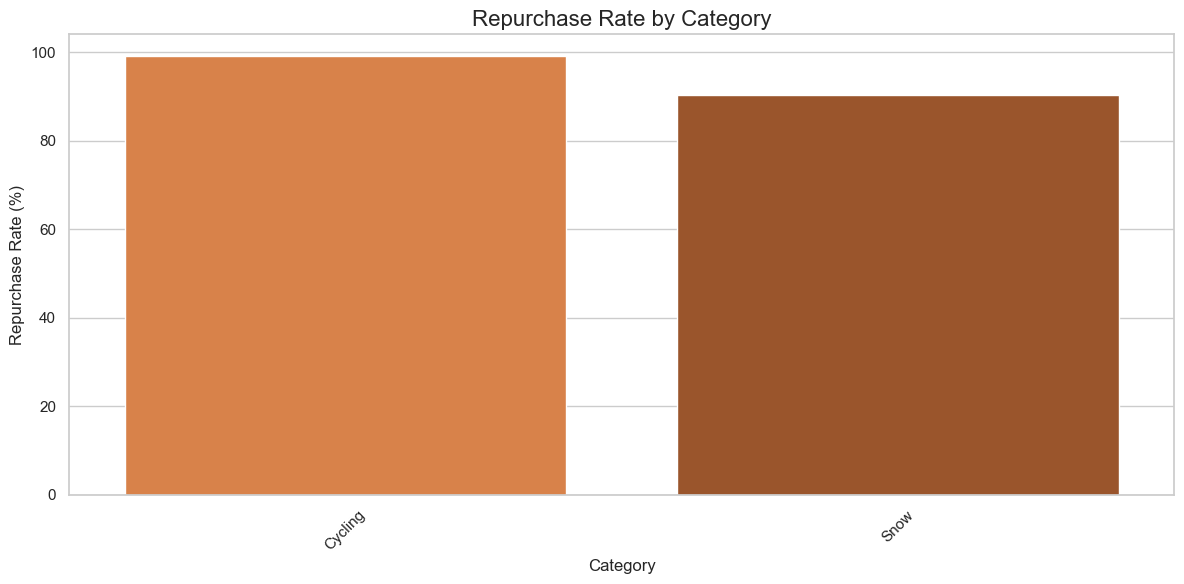

In [408]:
# Plotting Repurchase Rate by Category
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='repurchase_rate', data=repurchase_rate_category, palette='Oranges_d')
plt.title('Repurchase Rate by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Repurchase Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### Customer lifespan value(CLV)

In [493]:
#1 Average Order Value (AOV)
AOV = order_df['order_revenue'].mean() ##calculated the AOV

#2 Calculate Purchase Frequency (Total)
unique_customers = order_df['customer_id'].nunique()
purchase_frequency = total_orders / unique_customers  ## calculating the purchase frequency of customers

#3 Average Customer Lifespan (assuming 2 years)
average_customer_lifespan = 2 # CLV for a life span of 2 years

#4 CLV (Total)
CLV_total = AOV * purchase_frequency * average_customer_lifespan
print("Average Customer Lifespan value is:", CLV_total)
print("Average purchase frequency is",purchase_frequency)
print("AOV is",AOV)

Average Customer Lifespan value is: 9863.12
Average purchase frequency is 10.0
AOV is 493.156


In [495]:
###unique customers acquired and inactive customer.


order_df_2022 = order_df[order_df['year'] == 2022]
order_df_2023 = order_df[order_df['year'] == 2023]


customers_2022 = set(order_df_2022['customer_id'].unique())
customers_2023 = set(order_df_2023['customer_id'].unique())

new_customers_2023 = customers_2023 - customers_2022

num_new_customers_2023 = len(new_customers_2023)

print(f"Number of unique customers acquired in 2023: {num_new_customers_2023}")
print(len(customers_2023))
print(len(customers_2022))

all_customers = set(range(1, 1001))

order_df_2022_2023 = order_df[order_df['year'].isin([2023])]

active_customers = set(order_df_2022_2023['customer_id'].unique())

inactive_customers = all_customers - active_customers

inactive_customers_info = order_df[order_df['customer_id'].isin(inactive_customers)][['customer_id', 'country_name']].drop_duplicates()

print("Inactive customers and their countries:")
print(inactive_customers_info)


Number of unique customers acquired in 2023: 13
998
987
Inactive customers and their countries:
      customer_id country_name
122           128       Sweden
9452          913      Austria


## Profitability Calculation
<br>
Revenue Calculation:

Revenue can be calculated directly from the dataset using the column order_revenue, which represents the total amount earned from each order.<br>
<br>
Total Revenue = Sum of all values in the 'order_revenue' column.<br>
<br>
To calculate profitability accurately, we need to account for the following cost factors:<br>
<br>
1. Cost of Goods Sold (COGS): <br>
Represents the direct cost of producing the goods that were sold.<br>
Assume a fixed percentage of the price for each product to calculate COGS, which could be 40-50% of the product price for the E- commerce industry.<br>
COGS = units_sold * (cost per unit of product).<br>
<br>
2. Shipping and Fulfillment Costs:<br>
These costs include expenses for packaging, shipping, handling, and logistics.<br>
Assume a fixed cost per order or a percentage of the order value. For instance, we can assume shipping costs are 5-10% of the order_revenue.<br>
<br>
3. Marketing and Advertising Costs:<br>
The amount spent on marketing campaigns to drive traffic to the website and promote products.<br>
Assume a fixed percentage of revenue (e.g., 10-15%) for marketing expenses.<br>
<br>
4. Transaction Fees:<br>
Includes credit card fees, payment gateway charges, and other transaction-related fees.<br>
Typically around 2-3% of the total order value.<br>
<br>
5. Operating Costs:<br>
Fixed costs associated with running the business (e.g., salaries, rent, software, technology costs).<br>
Assume a monthly fixed cost that can be spread evenly across the orders in the dataset (for example 1000 euros per month.)<br>
<br>
6. Returns and Refunds:<br>
Some products might be returned or refunded, which directly impacts profitability.<br>
Assume a return rate and subtract the cost of returned items from the revenue.<br>
<br>
7. Customer Acquisition Cost (CAC): <br>
This is the cost associated with acquiring a new customer, including expenses on marketing, sales, promotions, and any other related activities.<br>
In our case, we can assume a fixed cost or a percentage of the marketing expenses that goes towards acquiring new customers.<br>
Assumptions for CAC<br>
Assume that 40% of the total marketing costs are used for customer acquisition.<br>
CAC can be calculated as:<br>
CAC = 0.4 * Marketing Costs<br>
<br>
8. Tax rate:<br>
This is the cost asscociated with the taxes to be paid on the gross profit earned on each order.<br>
Assume that tax rate is 20% on profit.<br>
Tax = 0.2 * Gross Profit<br>
<br>



#### Gross Profit = Total Revenue−(COGS+Shipping Costs+Marketing Costs+Transaction Fees+Operating Costs+Return Costs+CAC) <br>
#### Net Profit = Gross Profit - Tax

In [441]:
# Assumptions for cost calculations
COGS_percentage = 0.4  # Cost of Goods Sold as 60% of the price
shipping_percentage = 0.08  # Shipping costs as 8% of order revenue
marketing_percentage = 0.12  # Marketing costs as 12% of order revenue
transaction_fee_percentage = 0.025  # Transaction fees as 2.5% of order revenue
return_rate_percentage = 0.05  # Return costs as 5% of order revenue
monthly_operating_cost = 10000  # Fixed monthly operating costs
CAC_percentage = 0.4  # Customer Acquisition Cost as 40% of marketing costs
Tax_percentage = 0.2

df=order_df
# Calculate Cost of Goods Sold (COGS)
df['COGS'] = COGS_percentage * df['price'] * df['units_sold']

# Calculate Shipping and Fulfillment Costs
df['Shipping_Costs'] = shipping_percentage * df['order_revenue']

# Calculate Marketing Costs
df['Marketing_Costs'] = marketing_percentage * df['order_revenue']

# Calculate Transaction Fees
df['Transaction_Fees'] = transaction_fee_percentage * df['order_revenue']

# Calculate Return Costs
df['Return_Costs'] = return_rate_percentage * df['order_revenue']

# Calculate Operating Costs (distributing monthly fixed costs across the orders in that month)
monthly_order_count = df.groupby('month')['customer_id'].transform('count')
df['Operating_Costs'] = monthly_operating_cost / monthly_order_count

# Calculate Customer Acquisition Cost (CAC)
df['CAC'] = CAC_percentage * df['Marketing_Costs']

# Calculate Gross Profit for each order
df['Gross_Profit'] = df['order_revenue'] - (
    df['COGS'] + df['Shipping_Costs'] + df['Marketing_Costs'] + 
    df['Transaction_Fees'] + df['Operating_Costs'] + df['Return_Costs'] + df['CAC']
)

# Calculate Customer Acquisition Cost (CAC)
df['Tax'] = Tax_percentage * df['Gross_Profit']

# Calculate Net Profit for each order
df['Net_Profit'] = df['Gross_Profit'] - df['Tax']

# Display the first few rows of the dataset with the calculated profitability metrics
print(df[['order_revenue', 'COGS', 'Shipping_Costs', 'Marketing_Costs', 
          'Transaction_Fees', 'Operating_Costs', 'Return_Costs', 'CAC', 'Gross_Profit', 'Tax', 'Net_Profit']].head())


   order_revenue   COGS  Shipping_Costs  Marketing_Costs  Transaction_Fees  \
0           1960 784.00          156.80           235.20             49.00   
1             60  24.00            4.80             7.20              1.50   
2            200  80.00           16.00            24.00              5.00   
3            270 108.00           21.60            32.40              6.75   
4            520 208.00           41.60            62.40             13.00   

   Operating_Costs  Return_Costs   CAC  Gross_Profit    Tax  Net_Profit  
0            12.50         98.00 94.08        530.42 106.08      424.34  
1            11.11          3.00  2.88          5.51   1.10        4.41  
2            12.50         10.00  9.60         42.90   8.58       34.32  
3            12.50         13.50 12.96         62.29  12.46       49.83  
4            10.00         26.00 24.96        134.04  26.81      107.23  


/var/folders/kc/vbh30fpj45j8gf55k5hl7vbr0000gn/T/ipykernel_5284/359065609.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_order_count = df.groupby('month')['customer_id'].transform('count')


## Data Science and Machine Learning Techniques 

### 1. **Forecasting**
* **Problem being solved:** Predict future sales, revenue, or demand.
* **Approach:** Use time-series forecasting models like ARIMA, Prophet.
* **How it helps:**
    * **Improves inventory management:** Ensures products are in stock based on forecasted demand, reducing lost sales or revenue due to stockouts.
    * **Revenue Optimization:** Forecasting trends could optimize the timing of promotions to increase order size during high demand, ultimately improving AOV.

### 2. **Product Recommendations**
* **Problem being solved:** Suggest products to customers based on their past behavior or purchases.
* **Approach:** Use models like Collaborative Filtering, Content-Based Filtering, or Matrix Factorization (SVD) to recommend products.
* **How it helps:**
    * **Cross-sell/Up-sell:** By recommending related products, you increase the customer’s basket size and recommending complementary products will lead to higher AOV and hence revenue.
    * **Improves customer experience:** Personalized product recommendations keep customers engaged, increasing loyalty and hence can increase repurchase rate.

### 3. **Customer Segmentation**
* **Problem being solved:** Group customers based on their behaviors, preferences, or demographics.
* **Approach:** Use K-Means Clustering, Hierarchical Clustering, or DBSCAN to identify segments.
* **How it helps:**
    * **Personalized Marketing:** Segmentation allows for more targeted campaigns, targeted efforts will lead to higher engagement, retention, and low churn, which improve conversion rates.
    * **Loyalty programs:** Tailoring loyalty offers to high-value customers can increase retention and hence can increase CLV for them.

### 4. **Price Optimization**
* **Problem being solved:** Find the optimal price point that maximizes profit without reducing sales.
* **Approach:** Use Regression models or algorithms like gradient descent for dynamic pricing, considering factors like demand, competition, seasonality, and customer behavior.
* **How it helps:**
    * **Maximizes profit:** Adjusting pricing based on demand and elasticity ensures better margins and hence higher AOV and profits.
    * **Increases sales volume:** Dynamic pricing can help attract customers when demand is low and hence boost total revenue and profits.

### 5. **Churn Prediction & Optimization**
* **Problem being solved:** Identify customers at risk of leaving the platform and take preventive actions.
* **Approach:** Use Logistic Regression, Random Forest, or XGBoost for churn prediction.
* **How it helps:**
    * **Prevents customer loss:** Early identification of churn enables you to retain customers through targeted campaigns or incentives. As reducing churn directly improves retention, retaining customers for a longer period increases their lifetime value and increase repeat purchases.
    * **Lowers acquisition costs:** Retaining existing customers is more cost-effective than acquiring new ones.

### 6. **Customer Lifetime Value (CLV) Prediction**
* **Problem being solved:** Estimate the future value of a customer based on their past behavior and transactions.
* **Approach:** Use Cohort Analysis, RFM (Recency, Frequency, Monetary) or models like CLV prediction models using Gradient Boosting or Neural networks.
* **How it helps:**
    * **Improves customer targeting:** Focus on high-CLV customers for loyalty programs or exclusive offers as improving CLV by understanding and retaining high-value customers boosts long-term profitability. Also, Identifying low-CLV customers helps in creating targeted win-back campaigns.
    * **Better resource allocation:** Helps in deciding how much to spend on retaining specific customer segments.